# LSTM models for track finding with 3D ACTS data

In this notebook, we apply the LSTM track-finding models to some 3D ACTS data.

In [1]:
# System
from __future__ import print_function
import os

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Locals
from models import build_lstm_model
from metrics import calc_hit_accuracy
from drawing import (draw_layers, draw_projections,
                     draw_3d_event, draw_train_history)

# Magic
%matplotlib notebook

Using TensorFlow backend.


## Data utilities

Some helper functions for extracting, cleaning, binning the data.

In [2]:
def calc_eta(theta):
    """Calculates eta from a theta value or flat array"""
    return -1. * np.log(np.tan(theta / 2.))

def calc_phi(rphi, r):
    """Calculates phi from rphi"""
    return rphi / r
# I vectorize it to work on an array of arrays
calc_phi = np.vectorize(calc_phi, otypes='O')

def filter_samples(idx, *arrays):
    """Apply a filter index to a list of arrays"""
    return map(lambda x: x[idx], arrays)

def filter_objects(idx, *arrays):
    """
    Apply array of filter indices to some object arrays.
    Each input array should be an array of arrays (dtype='O').
    """
    filt_func = np.vectorize(lambda x: x[idx], otypes='O')
    return map(lambda a: np.stack(filt_func(a)), arrays)

In [3]:
class ActsData():
    """Empty class for setting variables as attributes"""
    pass

def load_data(filenames):
    """
    Retrieve data from some input files.
    Returns a data object with attributes for each numpy array.
    """
    d = ActsData()
    f = np.concatenate([np.load(f, encoding='bytes') for f in filenames])
    # Track level truth quantities
    d.true_theta = f['truth_Theta']
    d.true_eta = calc_eta(d.true_theta)
    d.true_phi = f['truth_Phi']
    d.true_qop = f['truth_QoverP']
    d.true_pt = np.abs(1/d.true_qop)
    # Detector hit measurements
    d.nstep = f['Filter_nSteps']
    d.rphi = f['Meas_RPHI']
    d.z = f['Meas_z']
    d.r = f['Cyl_R']
    d.phi = calc_phi(d.rphi, d.r)
    return d

def clean_data(data, fix_phi=False):
    """
    Cleans up the data, selecting barrel tracks and good hits.
    """
    barrel_tracks = np.abs(data.true_eta) < 1
    d = ActsData()

    # filter out all tracks not perfectly in the barrel.
    d.true_theta, d.true_eta, d.true_phi, d.true_qop, d.true_pt = (
        filter_samples(barrel_tracks, data.true_theta, data.true_eta,
                       data.true_phi, data.true_qop, data.true_pt))
    d.nstep, d.rphi, d.z, d.r, d.phi = (
        filter_samples(barrel_tracks, data.nstep, data.rphi,
                       data.z, data.r, data.phi))

    # To select the actual layer hits, I select the indices of the steps
    # I want. I'm currently taking the middle of each detector layer triplet,
    # and ignoring all of the apparent "auxiliary" steps. This assumes
    # all tracks have the fixed 31 steps as previously discovered, so it's
    # a bit fragile and will need to be updated if the data changes.
    assert np.all(d.nstep == 31)
    #good_hit_idxs = np.array([1, 4, 9, 11, 14, 17, 20, 24, 27])
    good_hit_idxs = np.array([2, 5, 8, 11, 15, 18, 21, 25, 28])
    d.rphi, d.z, d.r, d.phi = filter_objects(
        good_hit_idxs, d.rphi, d.z, d.r, d.phi)

    # Current data has some funny artifacts in phi.
    # Here is a shitty, hacky correction. Needs to be fixed upstream.
    if fix_phi:
        for i in range(d.phi.shape[1]):
            phi = d.phi[:,i]
            phi = phi * np.pi * 2 / (phi.max() - phi.min())
            d.phi[:,i] = phi - phi.min() - np.pi

    # Calculate theta
    d.theta = np.arctan(d.r / d.z)
    # Fix negative values so theta ranges from (0, pi)
    negidx = d.theta < 0
    d.theta[negidx] = d.theta[negidx] + np.pi
    d.eta = calc_eta(d.theta)

    return d

def hist2d_r_phi(data, det_shape, phi_range=(-3.1416, 3.1416)):
    """Takes the track hit data and bins it in 2D histogram detector images"""
    num_tracks = len(data.true_pt)
    # Initial structure with zeros
    tracks = np.zeros((num_tracks,) + det_shape)
    # Loop over tracks and layers
    for itrk in range(num_tracks):
        for jlay in range(det_shape[0]):
            # Convert coordinates for this layer to a histogram
            tracks[itrk, jlay] = np.histogram(
                data.phi[itrk, jlay:jlay+1],
                bins=det_shape[1], range=phi_range)[0]
    # Check that all tracks have one hit in every layer
    assert np.all(tracks.sum(axis=2) == 1.)
    return tracks

def hist3d_r_phi_z(data, det_shape, phi_range, z_range):
    """Takes the track hit data and bins it in 2D histogram detector images"""
    num_tracks = len(data.true_pt)
    # Initial structure with zeros
    tracks = np.zeros((num_tracks,) + det_shape)
    # Loop over tracks and layers
    for itrk in range(num_tracks):
        for jlay in range(det_shape[0]):
            # Convert coordinates for this layer to a histogram
            tracks[itrk, jlay] = np.histogram2d(
                data.phi[itrk, jlay:jlay+1],
                data.z[itrk, jlay:jlay+1],
                bins=[num_phi_bins, num_z_bins],
                range=[phi_range, z_range])[0]
    # Check that all tracks have one hit in every layer
    assert np.all(tracks.sum(axis=3).sum(axis=2) == 1.)
    return tracks

def combine_events(events, num_combine):
    """Combine detector image events together by num_combine"""
    combined_events = []
    for ievt in range(int(events.shape[0]/num_combine)):
        istart = num_combine * ievt
        iend = num_combine * (ievt + 1)
        combined_events.append(sum(events[istart:iend]))
    return np.stack(combined_events)

In [4]:
def flatten_layers(data):
    """Flattens each 2D detector layer into a 1D array"""
    return data.reshape((data.shape[0], data.shape[1], -1))

## Load the data

In [5]:
#input_file = '/Users/sfarrell/Atlas/TrackML/acts_dev/data/KFTest_0000.npy'
input_dir = '/home/sfarrell/trackml/data'
input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
               if f.startswith('KFTest') and f.endswith('.npy')]

In [6]:
# Load the raw data
raw_data = load_data(input_files)
num_raw_tracks = len(raw_data.true_theta)
# Clean the data
data = clean_data(raw_data, fix_phi=True)
num_tracks = len(data.true_theta)
print('Number of raw tracks: %i, cleaned tracks: %i' % (num_raw_tracks, num_tracks))

Number of raw tracks: 100000, cleaned tracks: 26674


In [7]:
# Detector binning
num_det_layers = 9
num_phi_bins = 64
num_z_bins = 64
seed_size = 3
phi_range = (-3.1416, 3.1416)
z_range = (-1155, 1155)

det_shape = (num_det_layers, num_phi_bins, num_z_bins)

tracks_per_event = 16
num_events = int(num_tracks / tracks_per_event)

In [8]:
# Bin the data into discrete detector images
tracks = hist3d_r_phi_z(data, det_shape, phi_range=phi_range, z_range=z_range)

# Combine tracks into events
events = combine_events(tracks, tracks_per_event)

## Basic LSTM model

In [9]:
# Since we combined tracks together to make events,
# we need to repeat each event for each corresponding signal track
train1_events = np.repeat(events, tracks_per_event, axis=0)
train1_input = flatten_layers(train1_events)
train1_target = flatten_layers(tracks[:num_events*tracks_per_event])

# Set the seeds
train1_input[:,:seed_size,:] = train1_target[:,:seed_size,:]

In [10]:
train1_input.shape

(26672, 9, 4096)

In [25]:
# Model config
hidden_dim = 128

# Training config
batch_size = 32
num_epoch = 30
val_frac = 0.1

In [26]:
model1 = build_lstm_model(num_det_layers, num_phi_bins*num_z_bins, hidden_dim=16)
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 9, 4096)       0                                            
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 9, 16)         263232      input_2[0][0]                    
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribut (None, 9, 4096)       69632       lstm_2[0][0]                     
Total params: 332,864
Trainable params: 332,864
Non-trainable params: 0
____________________________________________________________________________________________________


In [27]:
history1 = model1.fit(train1_input, train1_target,
                      validation_split=val_frac,
                      nb_epoch=num_epoch, batch_size=batch_size)
train1_pred = model1.predict(train1_input)

Train on 24004 samples, validate on 2668 samples
Epoch 1/30
24004/24004 [==============================] - 22s - loss: 7.4197 - acc: 0.0026 - val_loss: 7.1035 - val_acc: 0.0017
Epoch 2/30
24004/24004 [==============================] - 21s - loss: 6.9830 - acc: 0.0032 - val_loss: 6.9248 - val_acc: 0.0026
Epoch 3/30
24004/24004 [==============================] - 21s - loss: 6.7999 - acc: 0.0077 - val_loss: 6.6499 - val_acc: 0.0110
Epoch 4/30
24004/24004 [==============================] - 21s - loss: 6.4119 - acc: 0.0192 - val_loss: 6.2269 - val_acc: 0.0255
Epoch 5/30
24004/24004 [==============================] - 21s - loss: 5.9533 - acc: 0.0403 - val_loss: 5.7543 - val_acc: 0.0664
Epoch 6/30
24004/24004 [==============================] - 21s - loss: 5.3940 - acc: 0.1046 - val_loss: 5.1560 - val_acc: 0.1465
Epoch 7/30
24004/24004 [==============================] - 21s - loss: 4.7403 - acc: 0.1890 - val_loss: 4.5113 - val_acc: 0.2314
Epoch 8/30
24004/24004 [==============================]

<IPython.core.display.Javascript object>


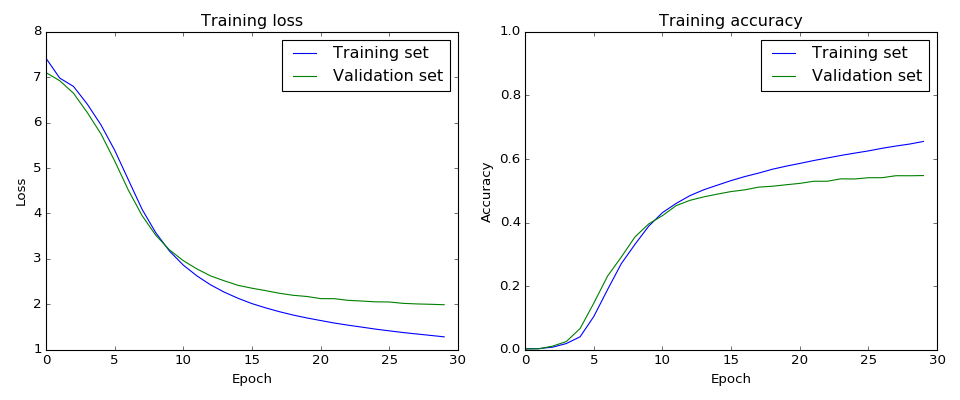

In [31]:
draw_train_history(history1);

In [30]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(train1_pred, train1_target,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
train1_scores = train1_pred * flatten_layers(train1_events)
hit_accuracy = calc_hit_accuracy(train1_scores, train1_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.499850029994
Accuracy of classified hit:  0.975596547357


Input data example event:


<IPython.core.display.Javascript object>


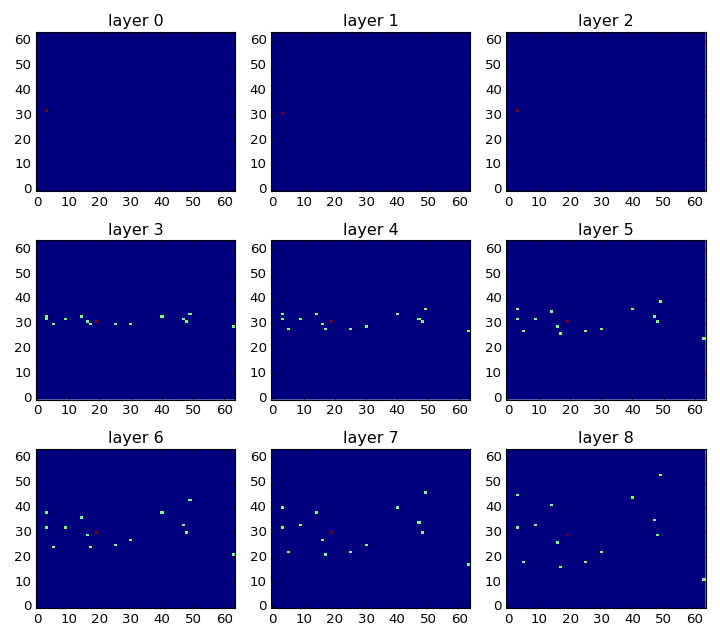

Model prediction:


<IPython.core.display.Javascript object>


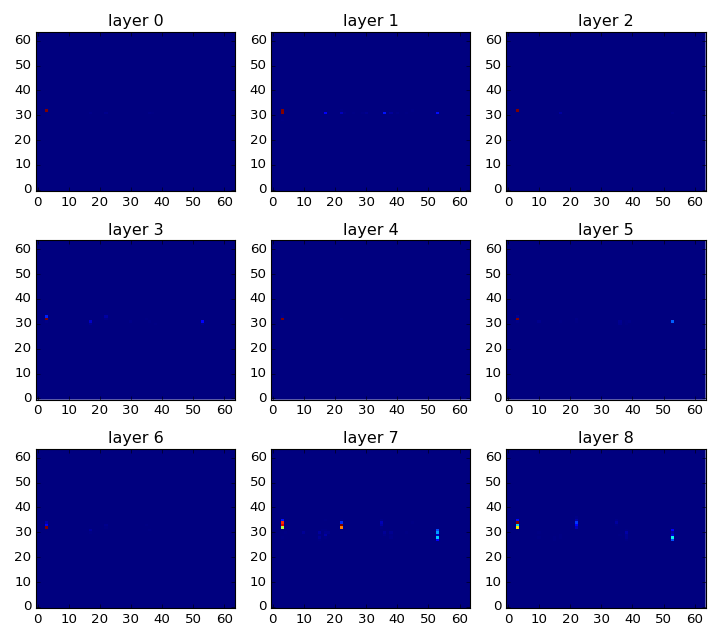

Projected input data:


<IPython.core.display.Javascript object>


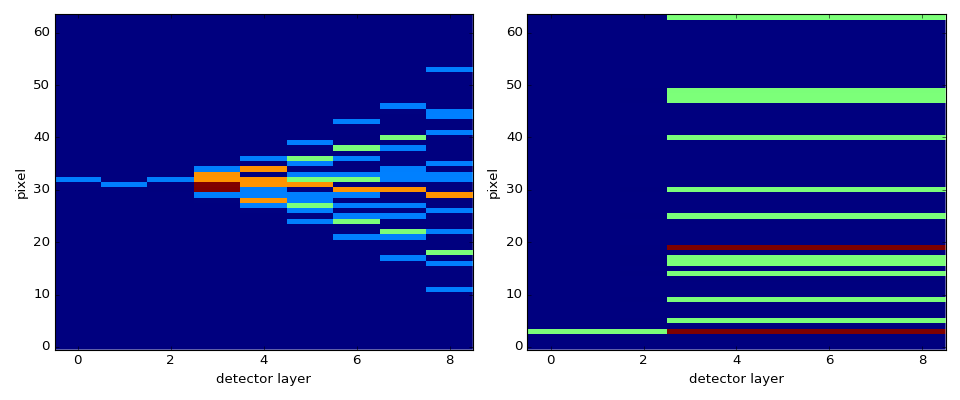

Projected model prediction:


<IPython.core.display.Javascript object>


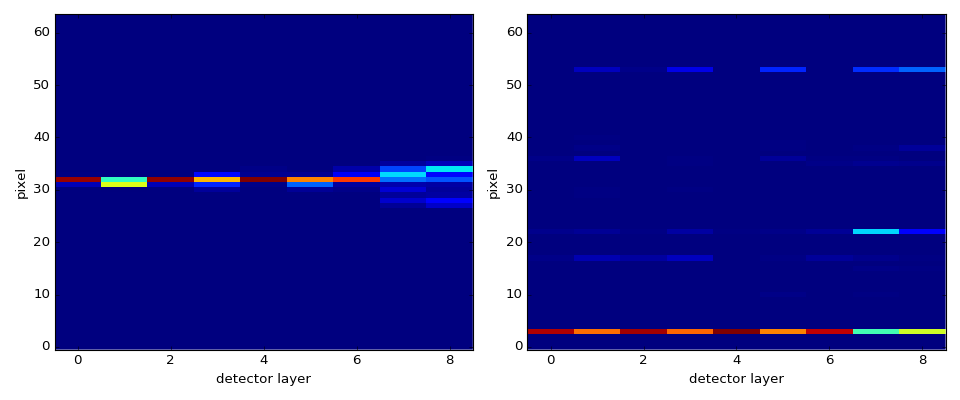

3D event and prediction:


<IPython.core.display.Javascript object>


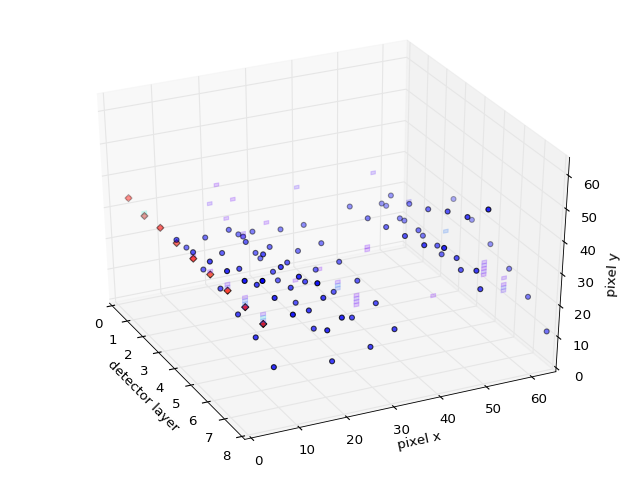

In [35]:
# Select an event to visualize
disp_idx = 5

# Draw the layers
print('Input data example event:')
draw_layers(train1_events[disp_idx], figsize=(9,8), ncols=3);
print('Model prediction:')
draw_layers(train1_pred[disp_idx].reshape(det_shape), figsize=(9,8), ncols=3)
print('Projected input data:')
draw_projections(train1_events[disp_idx])
print('Projected model prediction:')
draw_projections(train1_pred[disp_idx].reshape(det_shape));

print('3D event and prediction:')
draw_3d_event(train1_events[disp_idx],
              train1_target[disp_idx].reshape(det_shape),
              prediction=train1_pred[disp_idx].reshape(det_shape),
              pred_threshold=0.01);

# Need to adapt the truth coordinate drawing

# Get the hit coordinates for drawing
#idx = np.arange(num_det_layers)
#xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx],
#                                  idx, as_type=np.float32)
# Draw the layers
#print('Input data example event:')
#draw_layers(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
#print('Model prediction:')
#draw_layers(test_preds[disp_idx].reshape(det_shape),
#            truthx=xtruth, truthy=ytruth)
#print('Projected input data:')
#draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
#print('Projected model prediction:')
#draw_projections(test_preds[disp_idx].reshape(det_shape),
#                 truthx=xtruth, truthy=ytruth)